# Tree-Based models

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
# For random number generation
from scipy.stats import randint, uniform

from sklearn.experimental import enable_halving_search_cv # Allow importing the experimental HalvingGridSearchCV

# Metrics and auxiliar libraries from sklearn.
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# Some auxiliary functions for scoring.
import scoring_utils, tuning_utils

#DEV
import importlib as imp


In [2]:
# Import the dataframe cleaned during the feature importance process.
df = pd.read_csv('../data/data_clean.csv')
target = 'Default'

In [3]:
# Add UrbanRural one-hot encoded version diretly to the dataframe. That encoding is straighforward.
df = pd.get_dummies(data=df, columns=['UrbanRural'], prefix='UrbanRural')

all_features = [feature for feature in df.columns if feature not in target]

In [4]:
# Choose features for tree based-models using count encoding and then RFE
experimental_features = ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode']
features = [f for f in all_features if f not in experimental_features]
# Count encoding
count_encoded_features = ['City', 'Bank', 'State']
features_count_encoding = features + count_encoded_features

In [5]:
for feature in count_encoded_features:
    df[feature + 'Loans'] = df.groupby(feature)[feature].transform('count')
    df[feature + 'Loans'].fillna(0, inplace=True)

    features_count_encoding.remove(feature)
    features_count_encoding.append(feature+'Loans')

In [6]:
# Split for feature importance
X_train, X_, y_train, y_ = train_test_split(df[features_count_encoding], df[target], train_size=.75)

In [7]:
# Create Default Tree with all the features
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    min_samples_split=200,
    max_depth=16,
    class_weight='balanced'
    ).fit(X_train[features_count_encoding], y_train)

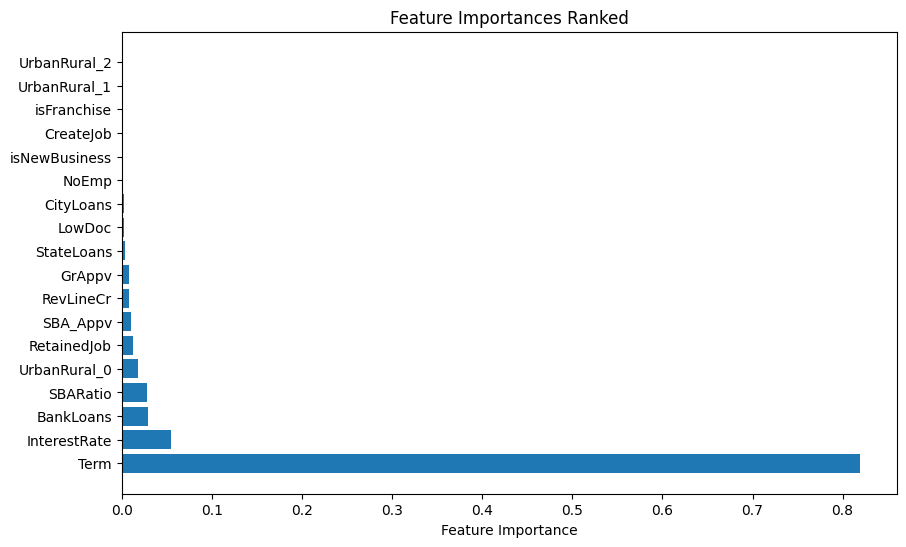

In [8]:
# Get feature importances from the trained model
importances = tree.feature_importances_

top_indices = np.argsort(importances)[::-1]

top_importances = importances[top_indices]
top_feature_names = np.array(features_count_encoding)[top_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances Ranked')
plt.show()

In [9]:
# I'ma peak the best 9
features_rfe = top_feature_names[:9]

In [69]:
# Prepare the data
X_total = df[features_rfe]
y_total = df[target]

X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, train_size=.85)

print(f"X -- Train shape: {X_train.shape}, test: {X_test.shape}")
print(f"y -- Train shape: {y_train.shape}, test: {y_test.shape}")


X -- Train shape: (739936, 9), test: (130578, 9)
y -- Train shape: (739936,), test: (130578,)


## Single tree
Optimized by weight.

In [70]:
weights = [.7, .75, .8, .85]

optimum_weight = 0
best_profit = 0

for weight in weights:
    model = DecisionTreeClassifier(
        max_depth=12,
        min_samples_split=200,
        class_weight={
            1: weight,
            0: (1-weight)
        }
    ).fit(X_train, y_train)
    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)
    print(f"Weight: {weight} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        optimum_weight = weight
        best_profit = profit

Weight: 0.7 , Profit: $6,492,594,606.00
Weight: 0.75 , Profit: $6,544,225,982.60
Weight: 0.8 , Profit: $6,559,365,047.55
Weight: 0.85 , Profit: $6,415,033,904.55


In [71]:
optimum_tree = DecisionTreeClassifier(
    max_depth=12,
    min_samples_split=200,
    class_weight={
        1: optimum_weight,
        0: (1-optimum_weight)
    }
).fit(X_train, y_train)

In [72]:
best_cutoff = tuning_utils.get_cutoff(optimum_tree, X_total, y_total)

Cutoff: 0.4 , Profit: $6,495,795,014.40
Cutoff: 0.45 , Profit: $6,522,919,686.95
Cutoff: 0.5 , Profit: $6,559,283,907.55
Cutoff: 0.525 , Profit: $6,570,096,411.40
Cutoff: 0.55 , Profit: $6,575,753,928.90
Cutoff: 0.575 , Profit: $6,569,897,522.05
Cutoff: 0.6 , Profit: $6,560,664,424.85


In [73]:
yhat_train = model.predict_proba(X_train)[:,1]
yhat_test = model.predict_proba(X_test)[:,1]

variance_check_tree = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train>best_cutoff, "Single Tree Train"),
    scoring_utils.get_metrics(y_test, yhat_test>best_cutoff, "Single Tree Test")
])

variance_check_tree

,Recall,Precision,ROC,F1
Single Tree Train,0.926852,0.666376,0.915339,0.775322
Single Tree Test,0.919658,0.659037,0.911019,0.767835


In [75]:
yhat_total = optimum_tree.predict_proba(X_total)[:,1]
score_tree = scoring_utils.get_metrics_and_profit(X_total, y_total, yhat_total>best_cutoff, "Single Tree")
score_tree

,Recall,Precision,ROC,F1,"Profit, $"
Single Tree,0.908314,0.714229,0.916553,0.799664,"6,575,753,928.90"


## Bagging


In [76]:
from sklearn.ensemble import BaggingClassifier

#Optimize for number of estimators

estimators = [10, 20, 30, 50, 60]

best_estimator = 0
best_profit = 0

for estimator in estimators:
    model = BaggingClassifier(
        optimum_tree,
        n_jobs=-1,
        n_estimators=estimator
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Estimators: {estimator} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        best_estimator = estimator
        best_profit = profit

Estimators: 10 , Profit: $6,585,516,519.50
Estimators: 20 , Profit: $6,636,418,983.40
Estimators: 30 , Profit: $6,628,931,051.00
Estimators: 50 , Profit: $6,634,642,132.85
Estimators: 60 , Profit: $6,657,177,302.25


In [77]:
# Optimize for max_features for training

features = [.5, .6, .7, .8, .9, 1.0]

best_feature = 0
best_profit = 0

for feature in features:
    model = BaggingClassifier(
        optimum_tree,
        n_jobs=-1,
        max_features=feature,
        n_estimators=best_estimator
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Max features: {feature} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        best_feature = feature
        best_profit = profit

Max features: 0.5 , Profit: $6,431,590,072.50
Max features: 0.6 , Profit: $6,760,159,959.35
Max features: 0.7 , Profit: $6,733,495,917.80
Max features: 0.8 , Profit: $6,736,404,656.75
Max features: 0.9 , Profit: $6,676,344,658.40
Max features: 1.0 , Profit: $6,652,115,758.65


In [78]:
# Optimize for max_samples for training

samples = [.3, .4, .5, .6, .7, .8, .9, 1.0]

best_sample = 0
best_profit = 0

for sample in samples:
    model = BaggingClassifier(
        optimum_tree,
        n_jobs=-1,
        max_features=best_feature,
        max_samples=sample,
        n_estimators=best_estimator
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Max samples: {sample} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        best_sample = sample
        best_profit = profit

Max samples: 0.3 , Profit: $6,704,508,064.70
Max samples: 0.4 , Profit: $6,699,360,294.15
Max samples: 0.5 , Profit: $6,706,273,299.60
Max samples: 0.6 , Profit: $6,727,270,888.10
Max samples: 0.7 , Profit: $6,710,817,118.40
Max samples: 0.8 , Profit: $6,736,335,546.45
Max samples: 0.9 , Profit: $6,639,879,646.05
Max samples: 1.0 , Profit: $6,679,237,677.35


In [79]:
optimum_bagging = BaggingClassifier(
    optimum_tree,
    max_features=best_feature,
    max_samples=best_sample,
    n_jobs=-1,
    n_estimators=best_estimator
).fit(X_train, y_train)

In [80]:
best_cutoff = tuning_utils.get_cutoff(optimum_bagging, X_total, y_total)

Cutoff: 0.4 , Profit: $6,702,058,210.65
Cutoff: 0.45 , Profit: $6,762,127,089.90
Cutoff: 0.5 , Profit: $6,720,255,561.85
Cutoff: 0.525 , Profit: $6,672,166,248.00
Cutoff: 0.55 , Profit: $6,595,948,977.05
Cutoff: 0.575 , Profit: $6,472,703,574.60
Cutoff: 0.6 , Profit: $6,337,565,216.30


In [82]:
yhat_train = optimum_bagging.predict_proba(X_train)[:,1]
yhat_test =optimum_bagging.predict_proba(X_test)[:,1]

variance_check_bagging = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train>best_cutoff, "Bagging Train"),
    scoring_utils.get_metrics(y_test, yhat_test>best_cutoff, "Bagging Test")
])

variance_check_bagging

,Recall,Precision,ROC,F1
Bagging Train,0.932441,0.723744,0.929337,0.814944
Bagging Test,0.926766,0.717190,0.925893,0.808619


In [83]:
yhat_total = optimum_bagging.predict_proba(X_total)[:,1]
score_bagging = scoring_utils.get_metrics_and_profit(X_total, y_total, yhat_total>best_cutoff, "Bagging")
pd.concat([
    score_tree,
    score_bagging
])

,Recall,Precision,ROC,F1,"Profit, $"
Single Tree,0.908314,0.714229,0.916553,0.799664,"6,575,753,928.90"
Bagging,0.931596,0.722766,0.928823,0.814000,"6,762,127,089.90"


## RandomForest

In [91]:
from sklearn.ensemble import RandomForestClassifier
def grid_search_forest(X_train, y_train):
    # Optimize using HalvingGridSearch from sklearn

    param_grid = {
        'max_features': [.6, .7, .8, .9, 1.0]
    }

    # Cross validation in 3 folds for our grid search parameter selection.
    # It must be consistent across the folds, so the random state has to be fixed.
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

    random_forest_search = HalvingGridSearchCV(
        estimator=RandomForestClassifier(
            max_depth=50,
            min_samples_split=10,
            n_estimators=100,
            class_weight={
                1: optimum_weight,
                0: (1-optimum_weight)
            }),
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1
    )

    random_forest_search.fit(X_train, y_train)

    print(scoring_utils.get_best_kernels(random_forest_search.cv_results_))

    return random_forest_search.best_estimator_


In [98]:

# This result was found running several times a GridSearch. If you want to run the grid search
# uncomment the function call, but take into account it is very computing intensive.

# Values found before using CV
best_forest = RandomForestClassifier(
    max_depth=20,
    min_samples_split=100,
    n_estimators=100,
    class_weight={
        1: optimum_weight,
        0: (1-optimum_weight)
    },
    max_samples=1.0,
    max_features=.7,
    n_jobs=-1 #Multicore makes this a little faster
).fit(X_train, y_train)

# The following line runs the gridsearch. Can take various hours!
# best_forest = grid_search_forest(X_train, y_train) # <- Uncomment to run GridSearch

In [100]:
cutoffs = [.35, .4, .45, .5, .55, .6, .65]

best_cutoff = 0
best_profit = 0

for cutoff in cutoffs:
    yprob = best_forest.predict_proba(X_total)[:,1]
    profit = scoring_utils.get_profit(X_total, y_total, (yprob>cutoff))
    print(f"Cutoff: {cutoff} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        best_cutoff = cutoff
        best_profit = profit

Cutoff: 0.35 , Profit: $6,688,649,561.85
Cutoff: 0.4 , Profit: $6,763,117,513.50
Cutoff: 0.45 , Profit: $6,807,997,947.70
Cutoff: 0.5 , Profit: $6,843,591,421.65
Cutoff: 0.55 , Profit: $6,851,928,867.70
Cutoff: 0.6 , Profit: $6,828,059,961.40
Cutoff: 0.65 , Profit: $6,774,989,290.75


In [110]:
yhat_train = best_forest.predict_proba(X_train)[:,1]
yhat_test = best_forest.predict_proba(X_test)[:,1]

variance_check_forest = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train>best_cutoff, "Random Forest Train"),
    scoring_utils.get_metrics(y_test, yhat_test>best_cutoff, "Random Forest Test")
])

variance_check_forest

,Recall,Precision,ROC,F1
Random Forest Train,0.926206,0.794447,0.938269,0.855282
Random Forest Test,0.907692,0.778442,0.927344,0.838113


In [111]:
yhat_total = best_forest.predict_proba(X_total)[:,1]
score_forest = scoring_utils.get_metrics_and_profit(X_total, y_total, yhat_total>best_cutoff, "Random Forest")
pd.concat([
    score_tree,
    score_bagging,
    score_forest
])

,Recall,Precision,ROC,F1,"Profit, $"
Single Tree,0.908314,0.714229,0.916553,0.799664,"6,575,753,928.90"
Bagging,0.931596,0.722766,0.928823,0.814000,"6,762,127,089.90"
Random Forest,0.923449,0.792063,0.936640,0.852725,"6,851,928,867.70"


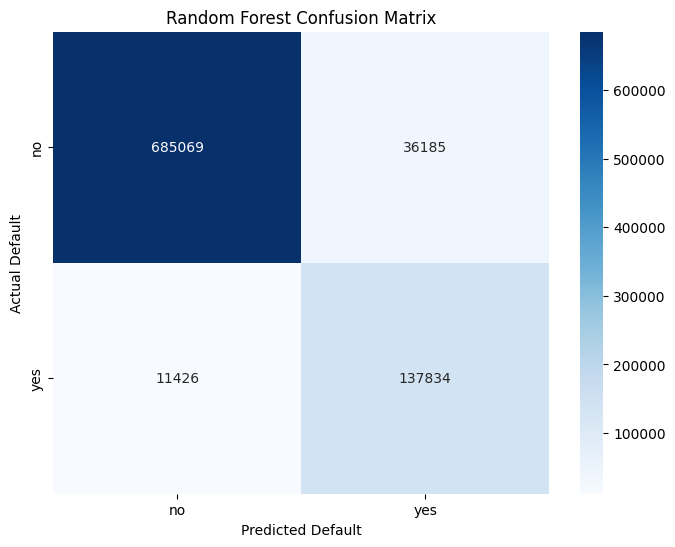

In [103]:
scoring_utils.get_confusion_matrix(y_total, yhat_total>best_cutoff, "Random Forest")

# Boosting

In [106]:
import xgboost as xgb

# Tune for weight

weights = [1.5, 2, 2.5, 3, 3.5, 4, 4.25, 4.5, 4.75, 5, 5.25]

best_weight = 0
best_profit = 0

for weight in weights:
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=weight
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Weight: {weight} , Profit: ${profit:,.2f}")

    if profit > best_profit:
        best_weight = weight
        best_profit = profit


Weight: 1.5 , Profit: $6,561,477,484.40
Weight: 2 , Profit: $6,640,875,976.05
Weight: 2.5 , Profit: $6,671,062,089.50
Weight: 3 , Profit: $6,681,300,542.15
Weight: 3.5 , Profit: $6,679,430,492.70
Weight: 4 , Profit: $6,672,543,515.50
Weight: 4.25 , Profit: $6,665,644,446.80
Weight: 4.5 , Profit: $6,656,201,331.10
Weight: 4.75 , Profit: $6,649,550,698.15
Weight: 5 , Profit: $6,643,789,657.05
Weight: 5.25 , Profit: $6,634,652,947.95


In [120]:
learning_rates = [ .2, .3, .35, .4, .45, .5, .6]

best_eta = 0
best_profit = 0

for learning_rate in learning_rates:
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=best_weight,
        eta=learning_rate
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Learning Rate: {learning_rate} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        best_eta = learning_rate
        best_profit = profit    

Learning Rate: 0.2 , Profit: $6,627,351,221.55
Learning Rate: 0.3 , Profit: $6,681,300,542.15
Learning Rate: 0.35 , Profit: $6,690,638,645.30
Learning Rate: 0.4 , Profit: $6,706,205,821.65
Learning Rate: 0.45 , Profit: $6,711,506,866.65
Learning Rate: 0.5 , Profit: $6,733,307,091.75
Learning Rate: 0.6 , Profit: $6,754,757,233.25


In [132]:
gammas = [0, .5, 1, 3, 5]

best_gamma = 0
best_profit = 0

for gamma in gammas:
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=best_weight,
        eta=.5,
        gamma=gamma
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Gamma: {gamma} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        best_gamma = gamma
        best_profit = profit    

Gamma: 0 , Profit: $6,733,307,091.75
Gamma: 0.5 , Profit: $6,742,960,515.40
Gamma: 1 , Profit: $6,745,113,572.20
Gamma: 3 , Profit: $6,682,721,764.05
Gamma: 5 , Profit: $6,651,395,210.80


In [133]:
best_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=best_weight,
    eta=.5,
    gamma=1
).fit(X_train, y_train)

In [134]:
best_cutoff = tuning_utils.get_cutoff(best_xgb, X_total, y_total)

Cutoff: 0.4 , Profit: $6,723,802,339.30
Cutoff: 0.45 , Profit: $6,740,107,736.95
Cutoff: 0.5 , Profit: $6,745,113,572.20
Cutoff: 0.525 , Profit: $6,737,106,194.55
Cutoff: 0.55 , Profit: $6,728,340,917.20
Cutoff: 0.575 , Profit: $6,713,698,123.20
Cutoff: 0.6 , Profit: $6,698,803,589.35


In [135]:
yhat_train = best_xgb.predict_proba(X_train)[:,1]
yhat_test = best_xgb.predict_proba(X_test)[:,1]

variance_check_boosting = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train>best_cutoff, "Boosting Train"),
    scoring_utils.get_metrics(y_test, yhat_test>best_cutoff, "Boosting Test")
])

variance_check_boosting

,Recall,Precision,ROC,F1
Boosting Train,0.911777,0.791465,0.930993,0.847372
Boosting Test,0.897976,0.775193,0.922273,0.832079


In [45]:
best_xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}